In [1]:

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [2]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(256, 256), transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.jpg'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        image = image.resize(self.img_size)
        mask = mask.resize(self.img_size)

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(np.array(mask), dtype=torch.long)

        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_dir = 'data/images'
mask_dir = 'data/masks'
dataset = SegmentationDataset(img_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
model = UNet(n_channels=3, n_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Finished Training')

# Save the model
model_save_path = 'path/to/save/model.pth'  # Specify your path here
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


  0%|          | 0/9 [00:04<?, ?it/s]


IndexError: Target 10 is out of bounds.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].


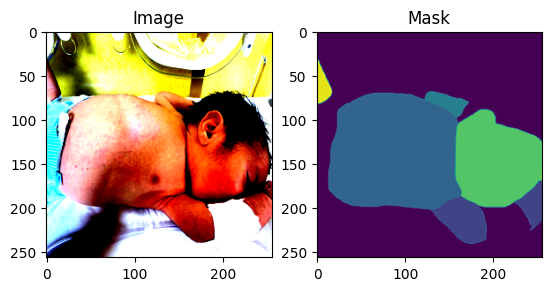

In [10]:
# Test loading a single sample
img_dir = 'data/images'
mask_dir = 'data/masks'
dataset = SegmentationDataset(img_dir, mask_dir, transform=transform)

# Check the first sample
image, mask = dataset[0]

# Display the image and mask
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0).numpy())  # Convert tensor to image format
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(mask.numpy())
plt.title('Mask')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_images=5):
    model.eval()
    for _ in range(num_images):
        idx = np.random.randint(0, len(dataset))
        image, mask = dataset[idx]
        image = image.unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(image)

        image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()
        prediction = torch.argmax(prediction.squeeze(), dim=0).cpu().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[0].set_title('Image')
        ax[1].imshow(mask)
        ax[1].set_title('Ground Truth')
        ax[2].imshow(prediction)
        ax[2].set_title('Prediction')
        plt.show()

# Visualize predictions
visualize_predictions(model, dataset)
